# Generation of hyperspectral samples using Wasserstein-GANs

Wasserstein-GANs are Generative Adversarial Models that can be used to generate synthetic data that approximates a specific input distribution of real data.

In this notebook, we show how to use such a tool to generate *ex nihilo* synthetic hyperspectral samples.

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
from PIL import Image


We load the Pavia University dataset. The `.mat` files are available on [this website](http://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes).

In [106]:
img = loadmat('./PaviaU.mat')['paviaU']
gt = loadmat('./PaviaU_gt.mat')['paviaU_gt']


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [113]:
img = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
img_rgb = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_rgb.tif')
# gt = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_labels.tif')
gt = io.imread('./gt_new.tif')

img = np.rot90(img,1,(0,2))
print(np.shape(img))
img_rgb =  np.rot90(img_rgb,1,(0,1))

print(np.shape(img_rgb))
# gt =  np.rot90(gt,1,(0,1))

# classes = np.array([
#     [153 ,  0 ,  0], #unspecified
#     [  0 ,  0 ,255], #roads
#     [  0, 255 ,  0], #vegetation
#     [  0 ,255 ,255], #water
#     [255 ,  0 ,0],#buidings 
#     [255 ,127 , 80]#cars
# ])
# # d = {
# #     repr([153 ,  0 ,  0]): 0,
# #     repr([0 ,  0 ,255]): 1,
# #     repr([ 0, 255 ,  0]): 2,
# #     repr([ 0 ,255 ,255]): 3,
# #     repr([255 ,  0 ,0]): 4,
# #     repr([255 ,127 , 80]): 5,
# # }
# gt_temp = np.zeros((gt.shape[0],gt.shape[1]))

# for i in range(gt.shape[0]):
#     for j in range(gt.shape[1]):
#         val = gt[i][j]
#         for id in range(len(classes)):
#             if np.array_equal(val, classes[id]):
#                 gt_temp[i][j] = id
        
        
# gt = gt_temp        
# gt_new = Image.fromarray(gt)
# gt_new.save('gt_new.tif')
print(gt.shape)


(3975, 1973, 51)
(3975, 1973, 3)
(3975, 1973)


In [115]:
mask = np.random.randint(0, 100, gt.shape) < 5
train_gt = np.copy(gt)

train_gt[np.nonzero(~mask)] = 0
test_gt = np.copy(gt)
test_gt[train_gt > 0] = 0
# (51, 1973, 3975)
# (1973, 3975, 3)
# (1973, 3975, 3)
# (610, 340, 103)
# (610, 340)
# (610, 340)
rgb = img_rgb
# rgb = img[:,:,(55,41,12)]
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
print(np.shape(img))
print(np.shape(gt))
print(np.shape(train_gt))
print(np.shape(rgb))

(3975, 1973, 51)
(3975, 1973)
(3975, 1973)
(3975, 1973, 3)


The ground truth is shown below. We sample 10% from the pixels as training samples.

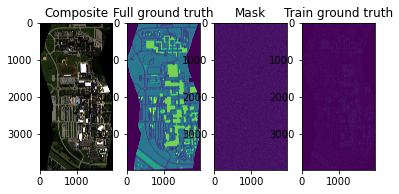

In [116]:
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)

plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

We define a `HyperX` class to hold the dataset. Note that the label is encoded as a one-hot vector.

In [117]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):
    
    def __init__(self, data, ground_truth, semi=False):
        super(HyperX, self).__init__()
        # Normalize the data in [0,1]
        data = (data - data.min()) / (data.max() - data.min())
        self.data = data
        self.gt = ground_truth
        self.n_classes = len(np.unique(ground_truth))
        if semi:
            # Semi-supervision, include neighbours at 50px
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
        else:
            x_pos, y_pos = np.nonzero(ground_truth)
        self.indices = [idx for idx in zip(x_pos, y_pos)]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, i):
        x, y = self.indices[i]
        data = self.data[x,y]
        # Get the label in one-hot encoded style
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')
        return torch.from_numpy(data), torch.from_numpy(label)

In [118]:
import os
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Basic generator that maps: noise + condition -> fake samples
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # LeakyReLU is preferred to keep gradients flowing even for negative activations
        self.generator = torch.nn.Sequential(
            torch.nn.Linear(z_dim + c_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, X_dim),
            torch.nn.Sigmoid() # smooth [0,1] outputs
        )
        self.apply(weight_init)

    def forward(self, z, c):
        # Concatenate the noise and condition
        inputs = torch.cat([z, c], 1)
        return self.generator(inputs)

# Basic fully connected discriminator: sample -> -infty -- fake - 0 - real -- +infty
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, 1)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

# Basic fully connected classifier: sample -> class
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, c_dim)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

In [119]:
mb_size = 256 # Batch size
z_dim = 30   # Noise dimension
X_dim = img.shape[-1] # Number of bands
print(X_dim)
h_dim = 512  # Hidden layer size
d_step = 5   # Number of discriminator training steps for each generator training step
lr = 5e-5    # Learning rate
c_weight = 0.2 # Auxiliary classifier weight
flip_percentage = 0.0 # Proportion of label flipping
mixup_alpha = 0.1 # Mixup
semi_supervised = True # semi-supervision (set to True to include unlabeled samples)

# Build the dataset and data loader
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)
# c_dim = condition vector size
c_dim = data_loader.dataset.n_classes

# Ignore the class 0
class_weights = torch.ones((c_dim))
class_weights[0] = 0.
class_weights = class_weights.cuda()

51


In [123]:
# Initialize weights using the He et al. (2015) policy.
def weight_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
        torch.nn.init.kaiming_normal_(m.weight.data)

# Spherical interpolation between two vectors on the unit hypersphere
# See : https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def lerp(val, low, high):
    return (1.0-val) * low + val * high # L'Hopital's rule/LERP

# Gradient penalty from the Improved WGAN training
# From : https://github.com/EmilienDupont/wgan-gp
# Use penalty_weight set at 10, as suggested in the paper
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
        batch_size = real_data.size()[0]

        alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        alpha = alpha.cuda()
        
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        #interpolated = Variable(interpolated, requires_grad=True)
        interpolated.requires_grad_()
        interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = netD(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return penalty_weight * ((gradients_norm - 1) ** 2).mean()
    
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()
        
def plot_mean_std(samples):
    mean_spectrum = np.mean(samples, axis=0)
    std_spectrum = np.std(samples, axis=0)
    plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std')
    plt.plot(mean_spectrum, label='mean')
    plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std')

In [124]:
# Get networks
G = Generator().cuda()
D = Discriminator().cuda()
C = Classifier().cuda()
# Use RMSProp optimizer
G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
C_solver = optim.RMSprop(C.parameters(), lr=lr)

for it in tqdm(range(100000)):
    ###########################
    # (1) Update C and D      #
    ###########################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for p in C.parameters():
        p.requires_grad = True
    
    # D is trained d_step times for each iteration
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
        print(X)
        D.zero_grad()

        # Sample random noise
        z = torch.randn(y.size(0), z_dim).squeeze()
        X, y = X.float(), y.float()
        X_, y_ = X_.float(), y_.float()
        # Mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        X = lam*X + (1. - lam)*X_
        X, y, z = X.cuda(), y.cuda(), z.cuda()
        y_ = y_.cuda()
        
        # Get discriminator prediction on real samples
        D_real = D(X).mean()
        # Get discriminator prediction on fake samples
        fake_samples = G(z, y)
        D_fake = D(fake_samples).mean()
        # Compute gradient penalty
        gradient_penalty = calc_gradient_penalty(D, X.data, fake_samples.data)
        # Compute loss and backpropagate
        D_loss = D_fake - D_real + gradient_penalty
        flip = np.random.random() < flip_percentage
        if flip: 
            # Flip real and fake
            gradient_penalty = calc_gradient_penalty(D, fake_samples.data, X.data)
            D_loss = D_real - D_fake + gradient_penalty
        D_loss.backward()
        D_solver.step()
    
        ######################
        #  Update C network  #
        ######################
        C.zero_grad()
        # Get class values
        _, classes = torch.max(y, dim=1)
        _, classes_ = torch.max(y_, dim=1)
        # Get predictions from C
        if flip:
            fake_samples = G(z, y)
            pred = C(fake_samples)
            # Compute loss and backpropagate
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)
        C_loss.backward()
        C_solver.step()


    ############################
    # (2) Update G network
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # to avoid computation
    for p in C.parameters():
        p.requires_grad = False
    reset_grad(C, G, D)

    # Sample random noise
    z = torch.randn(y.size(0), z_dim).squeeze()
    z = z.cuda()
    # Generate fake samples
    G_sample = G(z, y)
    D_fake = D(G_sample)
    pred = C(G_sample)
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)
    # Fool the discriminator (WGAN)
    G_loss = -torch.mean(D_fake)
    # Include the auxialiary classifier loss (AC-GAN)
    loss = G_loss + c_weight * C_loss
    # Backpropagate
    loss.backward()
    G_solver.step()

    # Print and plot every now and then
    if it % 1000 == 0:
        with torch.no_grad():
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                           D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                           C_loss.data.cpu().numpy()))
            z = torch.randn(mb_size, z_dim).squeeze().cuda()
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')
            idx = np.random.randint(1, data_loader.dataset.n_classes)
            c[:, idx] = 1.
            c = torch.from_numpy(c).squeeze().cuda()
            samples = G(z, c).data.cpu().numpy()[:16]
            pred = G(z, c)
            plot_mean_std(samples)
            plt.title("Samples for class {}".format(idx))
            plt.show()

  0%|          | 0/100000 [00:00<?, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Data generation

Now that the generator has been trained, we can generate some fake spectra and see how they fare visually against the real ones.

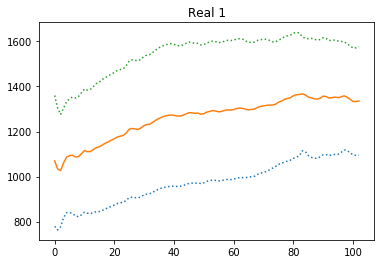

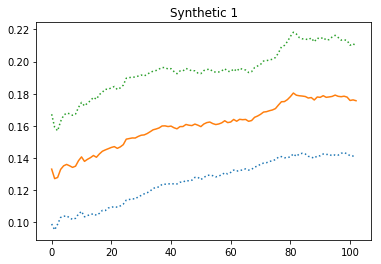

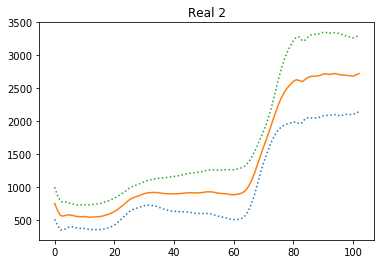

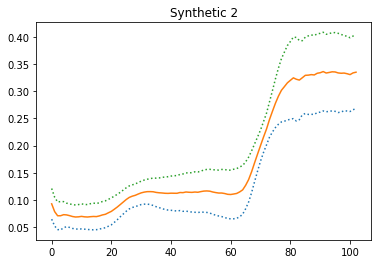

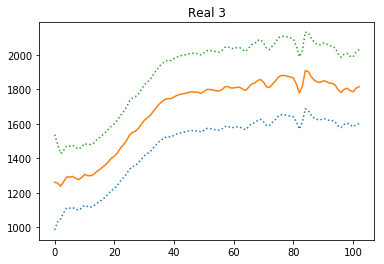

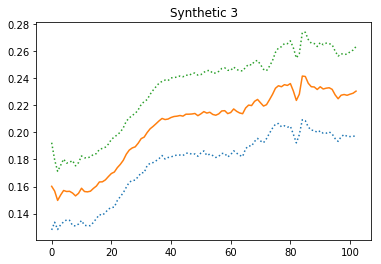

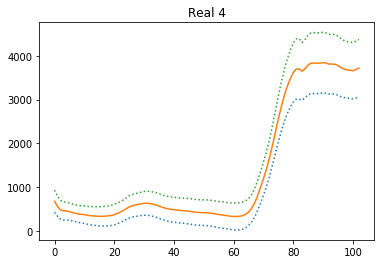

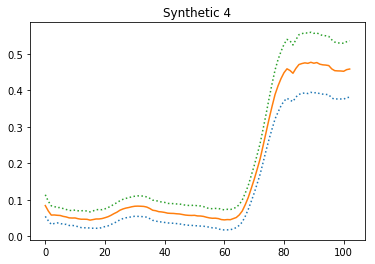

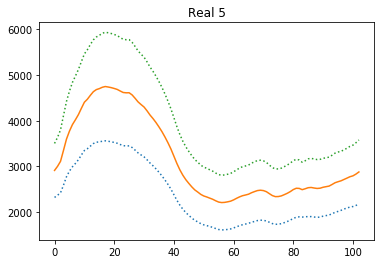

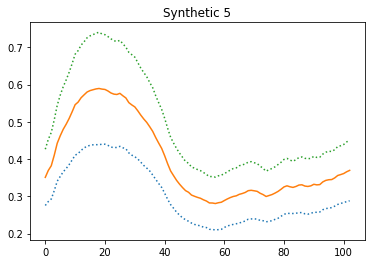

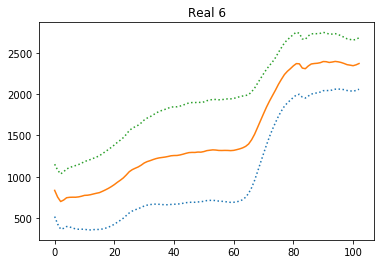

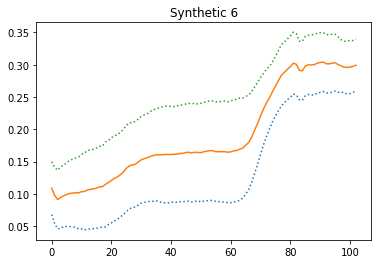

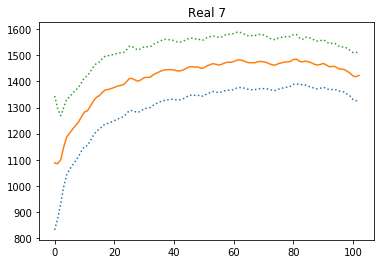

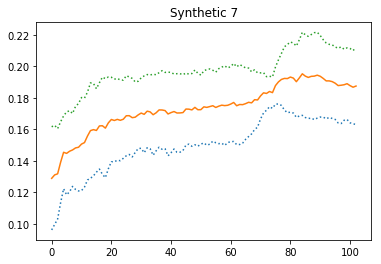

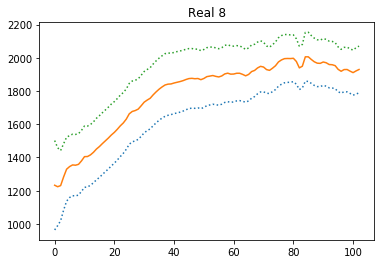

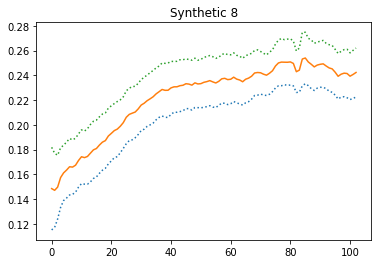

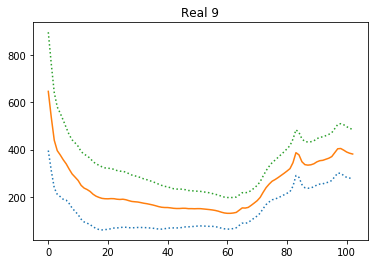

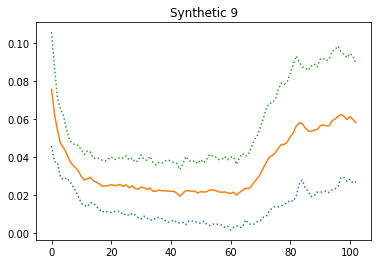

In [ ]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

## Evaluation

Finally, we want to compare the two distributions: is the fake distribution truely similar to the real distribution? To this end, we first can train a linear SVM on the real data and then apply it on the fake data. The frontiers of the real data should be respected by the fake data if the learning was successful.

In [ ]:
import sklearn.svm
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.mixture

In [ ]:
img = (img - img.min()) / (img.max() - img.min())
X_train = np.array([img[x,y] for x,y in zip(*np.nonzero(train_gt))])
y_train = np.array([gt[x,y] for x,y in zip(*np.nonzero(train_gt))])
X_test = np.array([img[x,y] for x,y in zip(*np.nonzero(test_gt))])
y_test = np.array([test_gt[x,y] for x,y in zip(*np.nonzero(test_gt))])

In [ ]:
gmms = [sklearn.mixture.GaussianMixture(n_components=20) for _ in range(c_dim)]
for y in np.unique(y_train):
    gmms[y].fit(X_train[y_train == y])

We can uncomment this code to use Gaussian Mixture Models instead of GANs.

In [ ]:
def gmm_create_fake_dataset(gmms, y):
    fake_X = []
    y_fake = []
    for y in np.unique(y):
        n_samples = np.count_nonzero(y_test == y)
        samples = gmms[y].sample(n_samples)[0]
        fake_X.append(samples)
        y_fake += [y] * n_samples
    fake_X = np.concatenate(fake_X)
    y_fake = np.array(y_fake)
    return fake_X, y_fake

#fake_X_train, fake_y_train = gmm_create_fake_dataset(gmms, y_train)
#fake_X_test, fake_y_test = gmm_create_fake_dataset(gmms, y_test)

### SVM on real data

Let's train a linear SVM on real data and see how it performs.

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
svm = sklearn.svm.SVC()
#estimator = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm)])
estimator = sklearn.pipeline.Pipeline(steps=[('svm', svm)])
#tuned_parameters = {'svm__C': [0.1, 1, 10, 100, 1000], 'svm__kernel': ['linear']}
tuned_parameters = {'svm__C': [1000], 'svm__kernel': ['linear']}
clf = sklearn.model_selection.GridSearchCV(estimator, tuned_parameters, cv=5, n_jobs=4)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
best_params = clf.best_params_
print("The best SVM was obtained using {} and performed at {:.2f} accuracy.".format(best_params, 100 * score))

The best SVM was obtained using {'svm__C': 1000, 'svm__kernel': 'linear'} and performed at 89.63 accuracy.


In [ ]:
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.85      0.94      0.89      6310
          2       0.93      0.96      0.94     17716
          3       0.79      0.72      0.75      2007
          4       0.93      0.90      0.91      2926
          5       1.00      1.00      1.00      1276
          6       0.87      0.78      0.82      4795
          7       0.83      0.48      0.61      1273
          8       0.83      0.84      0.84      3501
          9       1.00      1.00      1.00       891

avg / total       0.89      0.90      0.89     40695



### SVM on fake data

We now generate some fake data (in the same quantities as the real data) and apply the trained SVM on it.

In [ ]:
def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        for l in np.array_split(labels, len(labels) // mb_size):
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size())/10
            #y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)

In [ ]:
fake_X_train, fake_y_train = gan_create_fake_dataset(y_train)
fake_X_test, fake_y_test = gan_create_fake_dataset(y_test)

The true SVM performs better on fake data. Fake data is easier to separate, which means that it does not capture well boundaries between classes.

In [ ]:
clf.score(fake_X_test, fake_y_test)

0.959429905393783

In [ ]:
y_fake_pred = clf.predict(fake_X_test)
from sklearn.metrics import classification_report
print(classification_report(fake_y_test, y_fake_pred))

             precision    recall  f1-score   support

          1       0.92      0.96      0.94      6310
          2       0.97      0.99      0.98     17716
          3       0.97      0.88      0.92      2007
          4       0.99      0.96      0.98      2926
          5       0.96      1.00      0.98      1276
          6       0.95      0.93      0.94      4795
          7       0.93      0.65      0.77      1273
          8       0.94      0.96      0.95      3501
          9       1.00      0.95      0.97       891

avg / total       0.96      0.96      0.96     40695



We can also train a "fake" SVM on fake data. It separates the fake data nearly perfectly. However, it also neatly separates the true data. It is not as good as the true SVM, but still relatively good for synthetic data.

In [ ]:
svm_fake = sklearn.svm.SVC()
clf_fake = sklearn.pipeline.Pipeline(steps=[('svm', svm_fake)])
clf_fake.set_params(**clf.best_params_)
clf_fake.fit(np.concatenate([fake_X_train]), np.concatenate([fake_y_train]))

Pipeline(memory=None,
     steps=[('svm', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [ ]:
clf_fake.score(fake_X_test, fake_y_test)

0.992652660031945

In [ ]:
clf_fake.score(X_test, y_test)

0.8802801326944342

## Data augmentation

We can train on both real and fake data to use the latter as augmented data. However, as we saw the fake data does not capture class boundaries very well. Therefore, it only skews the SVM and worsen the accuracy.

In [ ]:
svm_augmented = sklearn.svm.SVC()
#clf_augmented = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm_augmented)])
clf_augmented = sklearn.pipeline.Pipeline(steps=[('svm', svm_augmented)])
clf_augmented.set_params(**clf.best_params_)
clf_augmented.fit(np.concatenate([X_train, fake_X_train]), np.concatenate([y_train, fake_y_train]))

Pipeline(memory=None,
     steps=[('svm', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [ ]:
clf_augmented.score(X_test, y_test)

0.8910185526477454

## Statistical analysis

We can apply a PCA to both the real and fake datasets to visually compare them. The distributions in the 2D main components are fairly similar, which is good!

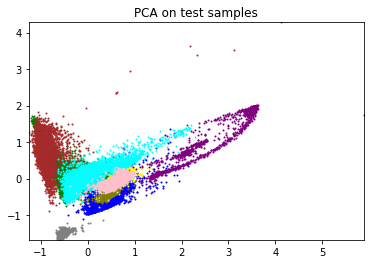

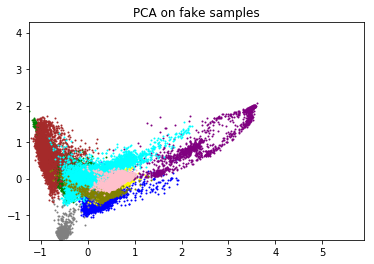

In [ ]:
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
x_min, x_max = np.min(X_pca[:,0]), np.max(X_pca[:,0])
y_min, y_max = np.min(X_pca[:,1]), np.max(X_pca[:,1])

colors = ['red', 'blue', 'green', 'yellow', 'brown', 'purple', 'cyan', 'olive', 'pink', 'gray']
for i, color in enumerate(colors):
    idx = y_test == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, s=1)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on test samples')
plt.show()

X_fake_pca = pca.transform(fake_X_test)
for i, color in enumerate(colors):
    idx = fake_y_test == i
    plt.scatter(X_fake_pca[idx, 0], X_fake_pca[idx, 1], s=1, c=color)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on fake samples')
plt.show()

We can train a neural network classifier on the real dataset and the augmented dataset (real + fake).

In [ ]:
def train(net, X_train, y_train, epochs=100):
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(),
                                             torch.from_numpy(y_train).long())
    loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
    solver = optim.Adam(net.parameters(), amsgrad=True)
    net.train()
    it = 0
    losses = []
    for _ in tqdm(range(epochs)):
        for X, y in loader:
            it += 1
            net.zero_grad()
            X, y = X.cuda(), y.cuda()
            out = net(X)
            loss = F.cross_entropy(out, y)
            loss.backward()
            solver.step()
            losses.append(loss.item())
            if it % 10000 == 0:
                print("Loss at {} = {}".format(it, loss.item()))
                plt.plot(losses) and plt.show()
    return net

In [ ]:
C_real = train(Classifier().cuda(), X_train, y_train, epochs=10000)

In [ ]:
def test(net, X_test, y_test):
    with torch.no_grad():
        net.eval()
        print(X_test.shape)
        print(y_test.shape)
        dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(),
                                                 torch.from_numpy(y_test).long())
        loader = torch.utils.data.DataLoader(dataset, batch_size=mb_size)
        pred = []
        for X, y in loader:
            X, y = X.cuda(), y.cuda()
            out = net(X)
            _, out = torch.max(out, 1)
            pred.append(out.cpu().numpy())
        pred = np.concatenate(pred)
        print(classification_report(y_test, pred, digits=4))
    return pred

In [ ]:
test(C_real, X_test, y_test)

(40695, 103)
(40695,)
             precision    recall  f1-score   support

          1     0.9350    0.9396    0.9373      6310
          2     0.9677    0.9741    0.9709     17716
          3     0.8540    0.7753    0.8127      2007
          4     0.9524    0.9429    0.9476      2926
          5     0.9976    0.9843    0.9909      1276
          6     0.9126    0.9101    0.9114      4795
          7     0.8450    0.8437    0.8443      1273
          8     0.8567    0.8815    0.8689      3501
          9     0.9989    0.9944    0.9966       891

avg / total     0.9377    0.9379    0.9377     40695



array([8, 1, 1, ..., 2, 2, 2])

In [ ]:
C_fake = train(Classifier().cuda(), np.concatenate((X_train, fake_X_train)), np.concatenate((y_train, fake_y_train)), epochs=10000)

The augmented classifier seems to work at least as well as the original one. This is encouraging for using GANs as a data augmentation strategy in a weakly-supervised hyperspectral image classification context.

In [ ]:
test(C_fake, X_test, y_test)

(40695, 103)
(40695,)
             precision    recall  f1-score   support

          1     0.9407    0.9483    0.9445      6310
          2     0.9679    0.9771    0.9725     17716
          3     0.8349    0.7912    0.8125      2007
          4     0.9688    0.9433    0.9558      2926
          5     0.9953    0.9961    0.9957      1276
          6     0.9204    0.9137    0.9170      4795
          7     0.8902    0.8594    0.8745      1273
          8     0.8625    0.8743    0.8684      3501
          9     0.9989    0.9888    0.9938       891

avg / total     0.9416    0.9419    0.9417     40695



array([8, 1, 1, ..., 2, 2, 2])